In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from os.path import isfile
from datetime import datetime
%matplotlib inline

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = Session(config=config)

if tf.test.gpu_device_name():
    print("GPU found")
else:
    print("No GPU found")

GPU found


## Load training and Validation arrays

In [3]:
#dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7}
dict_genres = {'Electronic':0, 'Experimental':1, 'Hip-Hop':3, 'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7}

reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [4]:
npzfile = np.load('data/shuffled_train.npz')
print(npzfile.files)

X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394,)


In [5]:
y_train_mask = np.in1d(y_train, list(dict_genres.values()))

In [6]:
y_train = y_train[y_train_mask]

In [7]:
y_train = utils.to_categorical(y_train, num_classes=8).astype(int)

In [8]:
X_train = X_train[y_train_mask]

In [9]:
X_train.shape, y_train.shape

((5594, 640, 128), (5594, 8))

In [10]:
npzfile = np.load('data/shuffled_valid.npz')
print(npzfile.files)

X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [11]:
y_valid_mask = np.in1d(y_valid, list(dict_genres.values()))

In [12]:
y_valid = y_valid[y_valid_mask]

In [13]:
y_valid = utils.to_categorical(y_valid, num_classes=8).astype(int)

In [14]:
X_valid = X_valid[y_valid_mask]

In [15]:
X_valid.shape, y_valid.shape

((700, 640, 128), (700, 8))

## Check by plotting a Spectogram

Pop


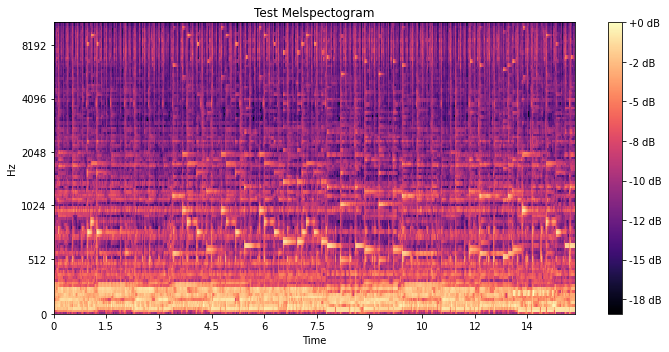

In [16]:
num = 0
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

## Parallel CNN - RNN Model

In [17]:
batch_size = 32
num_classes = 2
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [18]:
nb_filters1=32
nb_filters2=64
nb_filters3=128
nb_filters4=512
ksize = (3,3)
pool_size_1= (2,2)

BATCH_SIZE = 64
EPOCH_COUNT = 30

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D(pool_size_1)(conv_4)
    
    flatten1 = Flatten()(pool_4)
    
    output = Dense(num_classes, activation = 'softmax', name='preds')(flatten1)
    
    model_output = output
    model = Model(model_input, model_output)
    
    opt = Adam(learning_rate=0.001)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [19]:
def train_model(x_train, y_train, x_val, y_val, info = "", genres_name = ""):
    n_frames = 640
    n_frequency = 128
    
    #reshape and expand dims for conv2d
    x_train = np.expand_dims(x_train, axis = -1)
    x_val = np.expand_dims(x_val, axis = -1)
    
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
    log_dir = "./logs/tree_3/model_root_f1/"+datetime.now().strftime("%Y%m%d-%H%M%S_")+info
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=False, update_freq='batch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None)

    model_folder = "./models/tree_3/model_root_f1/{}".format(info)
    os.makedirs(model_folder, exist_ok=True)
    
    f = open("{}/info.txt".format(model_folder), "w")
    f.write("genre name split: {}".format(genres_name))
    checkpoint_callback = ModelCheckpoint('{}/model.h5'.format(model_folder), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1)
    callbacks_list = [tb_callback, checkpoint_callback, reducelr_callback]
    
    f.close()
    
    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT, validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)
    
    return model, history

In [20]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [21]:
def create_split(elem, c):
    splits = []
    for i in range(c):
        equal = False
        np.random.shuffle(elem)
        new_split = list(chunks(elem, int(len(elem)/2)))
        for split in splits:
            if set(new_split[0]) == set(split[0]) and set(new_split[0]) == set(split[1]):
                equal = True
                break
            
        if equal:
            i-=1
            continue
        
        splits.append(new_split)
        
    return splits

In [22]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Folder num 1
Genre split [['Electronic'], ['Experimental', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']]
Building model...
Training...
Epoch 1/30
87/87 [==============================] - 39s 166ms/step - loss: 0.5723 - accuracy: 0.8402 - val_loss: 0.4250 - val_accuracy: 0.8526

Epoch 00001: val_accuracy improved from -inf to 0.85260, saving model to ./models/tree_2/model_root_f1/folder1\model.h5
Epoch 2/30
87/87 [==============================] - 13s 147ms/step - loss: 0.3941 - accuracy: 0.8589 - val_loss: 0.4017 - val_accuracy: 0.8602

Epoch 00002: val_accuracy improved from 0.85260 to 0.86023, saving model to ./models/tree_2/model_root_f1/folder1\model.h5
Epoch 3/30
87/87 [==============================] - 13s 147ms/step - loss: 0.4056 - accuracy: 0.8551 - val_loss: 0.4807 - val_accuracy: 0.8386

Epoch 00003: val_accuracy did not improve from 0.86023
Epoch 4/30
87/87 [==============================] - 14s 159ms/step - loss: 0.3869 - accuracy: 0.8591 - val_loss: 0.4328 -

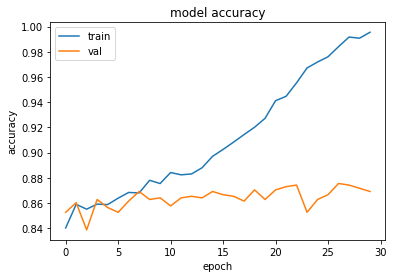

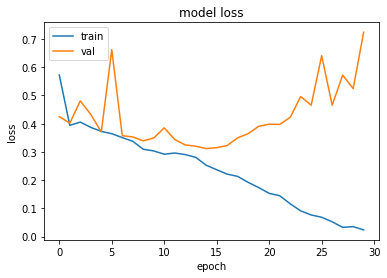

Folder num 2
Genre split [['Experimental'], ['Electronic', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']]
Building model...
Training...
Epoch 1/30
87/87 [==============================] - 15s 158ms/step - loss: 0.6756 - accuracy: 0.8478 - val_loss: 0.4078 - val_accuracy: 0.8590

Epoch 00001: val_accuracy improved from -inf to 0.85896, saving model to ./models/tree_2/model_root_f1/folder2\model.h5
Epoch 2/30
87/87 [==============================] - 13s 151ms/step - loss: 0.4040 - accuracy: 0.8569 - val_loss: 0.4114 - val_accuracy: 0.8590

Epoch 00002: val_accuracy did not improve from 0.85896
Epoch 3/30
87/87 [==============================] - 13s 149ms/step - loss: 0.3951 - accuracy: 0.8569 - val_loss: 0.3639 - val_accuracy: 0.8590

Epoch 00003: val_accuracy did not improve from 0.85896
Epoch 4/30
87/87 [==============================] - 15s 169ms/step - loss: 0.3826 - accuracy: 0.8562 - val_loss: 0.3923 - val_accuracy: 0.8590

Epoch 00004: val_accuracy did not improve fro

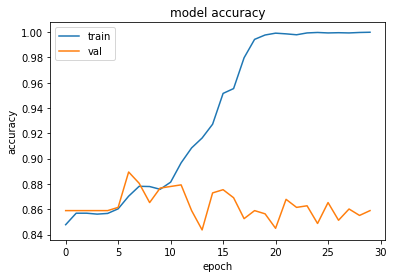

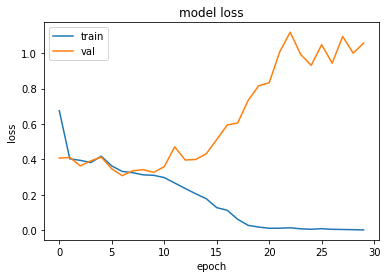

Folder num 3
Genre split [['Hip-Hop'], ['Electronic', 'Experimental', 'Instrumental', 'International', 'Pop', 'Rock']]
Building model...
Training...
Epoch 1/30
87/87 [==============================] - 16s 161ms/step - loss: 0.5733 - accuracy: 0.8417 - val_loss: 0.4348 - val_accuracy: 0.8577

Epoch 00001: val_accuracy improved from -inf to 0.85769, saving model to ./models/tree_2/model_root_f1/folder3\model.h5
Epoch 2/30
87/87 [==============================] - 13s 147ms/step - loss: 0.3922 - accuracy: 0.8575 - val_loss: 0.3348 - val_accuracy: 0.8577

Epoch 00002: val_accuracy did not improve from 0.85769
Epoch 3/30
87/87 [==============================] - 14s 158ms/step - loss: 0.3422 - accuracy: 0.8573 - val_loss: 0.3312 - val_accuracy: 0.8513

Epoch 00003: val_accuracy did not improve from 0.85769
Epoch 4/30
87/87 [==============================] - 13s 150ms/step - loss: 0.3120 - accuracy: 0.8596 - val_loss: 0.3200 - val_accuracy: 0.8628

Epoch 00004: val_accuracy improved from 0.857

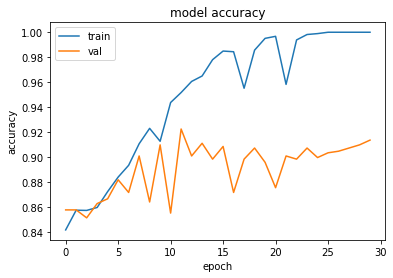

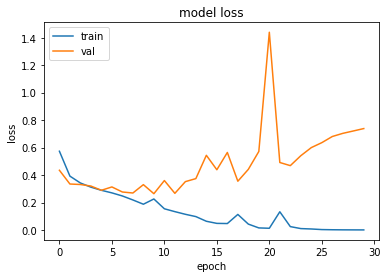

Folder num 4
Genre split [['Instrumental'], ['Electronic', 'Experimental', 'Hip-Hop', 'International', 'Pop', 'Rock']]
Building model...
Training...
Epoch 1/30
87/87 [==============================] - 15s 156ms/step - loss: 0.6286 - accuracy: 0.8487 - val_loss: 0.3962 - val_accuracy: 0.8513

Epoch 00001: val_accuracy improved from -inf to 0.85133, saving model to ./models/tree_2/model_root_f1/folder4\model.h5
Epoch 2/30
87/87 [==============================] - 13s 149ms/step - loss: 0.4162 - accuracy: 0.8476 - val_loss: 0.3451 - val_accuracy: 0.8513

Epoch 00002: val_accuracy did not improve from 0.85133
Epoch 3/30
87/87 [==============================] - 13s 151ms/step - loss: 0.3661 - accuracy: 0.8578 - val_loss: 0.3393 - val_accuracy: 0.8513

Epoch 00003: val_accuracy did not improve from 0.85133
Epoch 4/30
87/87 [==============================] - 13s 150ms/step - loss: 0.3354 - accuracy: 0.8595 - val_loss: 0.3524 - val_accuracy: 0.8755

Epoch 00004: val_accuracy improved from 0.851

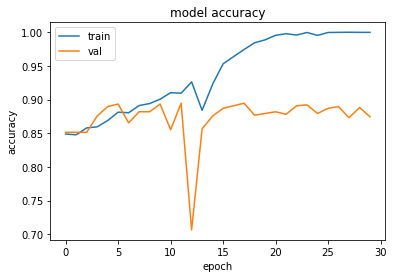

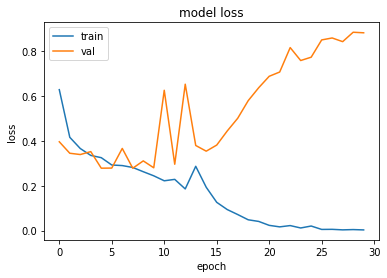

Folder num 5
Genre split [['International'], ['Electronic', 'Experimental', 'Hip-Hop', 'Instrumental', 'Pop', 'Rock']]
Building model...
Training...
Epoch 1/30
87/87 [==============================] - 14s 152ms/step - loss: 0.6397 - accuracy: 0.8495 - val_loss: 0.4551 - val_accuracy: 0.8513

Epoch 00001: val_accuracy improved from -inf to 0.85133, saving model to ./models/tree_2/model_root_f1/folder5\model.h5
Epoch 2/30
87/87 [==============================] - 13s 148ms/step - loss: 0.4328 - accuracy: 0.8576 - val_loss: 0.4231 - val_accuracy: 0.8513

Epoch 00002: val_accuracy did not improve from 0.85133
Epoch 3/30
87/87 [==============================] - 13s 148ms/step - loss: 0.4148 - accuracy: 0.8578 - val_loss: 0.4492 - val_accuracy: 0.8513

Epoch 00003: val_accuracy did not improve from 0.85133
Epoch 4/30
87/87 [==============================] - 13s 148ms/step - loss: 0.4132 - accuracy: 0.8580 - val_loss: 0.5550 - val_accuracy: 0.8526

Epoch 00004: val_accuracy improved from 0.851

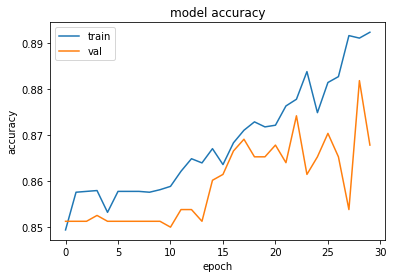

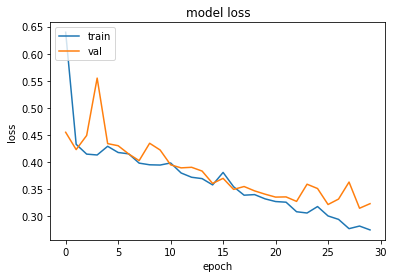

Folder num 6
Genre split [['Pop'], ['Electronic', 'Experimental', 'Hip-Hop', 'Instrumental', 'International', 'Rock']]
Building model...
Training...
Epoch 1/30
87/87 [==============================] - 15s 156ms/step - loss: 0.6113 - accuracy: 0.8411 - val_loss: 0.4648 - val_accuracy: 0.8615

Epoch 00001: val_accuracy improved from -inf to 0.86150, saving model to ./models/tree_2/model_root_f1/folder6\model.h5
Epoch 2/30
87/87 [==============================] - 13s 147ms/step - loss: 0.4173 - accuracy: 0.8564 - val_loss: 0.4022 - val_accuracy: 0.8615

Epoch 00002: val_accuracy did not improve from 0.86150
Epoch 3/30
87/87 [==============================] - 13s 149ms/step - loss: 0.4138 - accuracy: 0.8564 - val_loss: 0.3978 - val_accuracy: 0.8615

Epoch 00003: val_accuracy did not improve from 0.86150
Epoch 4/30
87/87 [==============================] - 13s 148ms/step - loss: 0.4110 - accuracy: 0.8564 - val_loss: 0.3969 - val_accuracy: 0.8615

Epoch 00004: val_accuracy did not improve fro

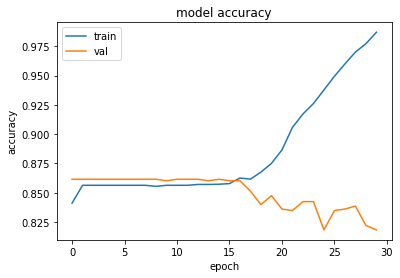

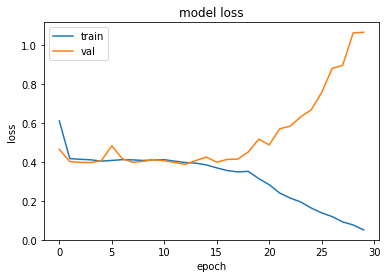

Folder num 7
Genre split [['Rock'], ['Electronic', 'Experimental', 'Hip-Hop', 'Instrumental', 'International', 'Pop']]
Building model...
Training...
Epoch 1/30
87/87 [==============================] - 17s 173ms/step - loss: 0.6138 - accuracy: 0.8519 - val_loss: 0.3781 - val_accuracy: 0.8410

Epoch 00001: val_accuracy improved from -inf to 0.84097, saving model to ./models/tree_2/model_root_f1/folder7\model.h5
Epoch 2/30
87/87 [==============================] - 13s 154ms/step - loss: 0.3571 - accuracy: 0.8593 - val_loss: 0.3461 - val_accuracy: 0.8397

Epoch 00002: val_accuracy did not improve from 0.84097
Epoch 3/30
87/87 [==============================] - 13s 151ms/step - loss: 0.3196 - accuracy: 0.8687 - val_loss: 0.3004 - val_accuracy: 0.8664

Epoch 00003: val_accuracy improved from 0.84097 to 0.86641, saving model to ./models/tree_2/model_root_f1/folder7\model.h5
Epoch 4/30
87/87 [==============================] - 13s 149ms/step - loss: 0.3112 - accuracy: 0.8722 - val_loss: 0.3216 -

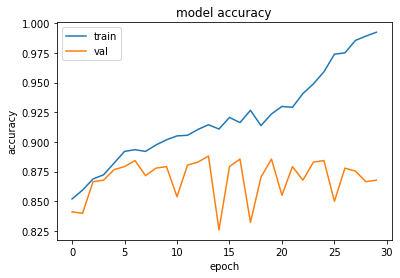

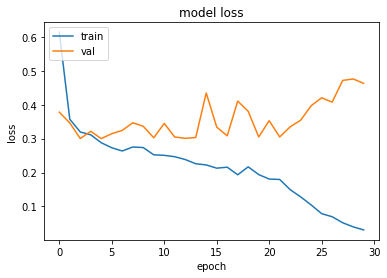

In [23]:
X_train_cross = np.concatenate((X_train, X_valid), axis=0)
y_train_cross = np.concatenate((y_train, y_valid), axis=0)

num_splits = 7

kfold = KFold(n_splits=8, shuffle=True)
genre_splits = create_split(list(dict_genres.values()), num_splits)

fold_no = 1
for train, test in kfold.split(X_train_cross, y_train_cross):
    #split = genre_splits[fold_no - 1]
    dict_genres_list = list(dict_genres.values())
    split = [[dict_genres_list.pop(fold_no - 1)], dict_genres_list]
    
    y_train_cross_binary = np.argmax(y_train_cross, axis=1)
    y_train_cross_binary = np.in1d(y_train_cross_binary, split[0])
    y_train_cross_binary = utils.to_categorical(y_train_cross_binary*1, num_classes=2)

    print("Folder num {}".format(fold_no))
    genres_name = [[reverse_map[g] for g in split_l] for split_l in split]
    print("Genre split {}".format(genres_name))
    
    model, history  = train_model(X_train_cross[train], y_train_cross_binary[train], X_train_cross[test], y_train_cross_binary[test], "folder{}".format(fold_no), genres_name)
    show_summary_stats(history)
    
    fold_no += 1
    if fold_no > num_splits:
        break